# NRTK End-to-End Overview

## Introduction

NRTK consists of two main parts:

1. **Image Perturbation**: The core of NRTK is based on image perturbation. NRTK offers a wide variety of ways to perturb images and transform bounding boxes. Perturbation classes take an image and perform a transformation based on input parameters.

2. **Perturbation Factories**: Building upon image perturbation, perturbation factories take a range of values for parameter(s) and perform multiple perturbations on the same image, allowing quick and simple generation of multiple perturbations.

The following sections will guide you through setting up and using an example perturber. By the end of this tutorial, you'll have a working example that you can expand for your own projects.

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/nrtk_tutorial.ipynb)

## Prerequisites

The below are prerequisites for this tutorial:

- **Software Requirements:**
  - Supported Python versions: ![PyPI - Python Version](https://img.shields.io/pypi/pyversions/nrtk)
  - pip (Python package manager) installed.
- **Basic Skills:** Familiarity with Python programming and using the terminal or command line.

The following sections will guide you through setting up and using an example perturber.

```{note}
We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that this cell is **not** executed so that any related warnings are shown.
```

In [1]:
import warnings

warnings.filterwarnings("ignore")

```{important}
This notebook requires NRTK with the following extra(s):

- `pybsm`: pyBSM sensor simulation library for physics-based optical transfer function perturbations
- `headless` (or `graphics`): OpenCV for graphical operations within pyBSM

The next cell will install these extra(s). See [Installation](<project:/getting_started/installation.rst>) for alternatives.
```

In [2]:
%pip install -qU pip
print("Installing nrtk with required extras...")
%pip install -q "nrtk[pybsm,headless]"
print("Done!")

from nrtk.utils._extras import print_extras_status  # noqa: E402 - intentionally after %pip install

print_extras_status()

Note: you may need to restart the kernel to use updated packages.
Installing nrtk with required extras...


Note: you may need to restart the kernel to use updated packages.
Done!


Detected status of NRTK extras and their dependencies:



[albumentations]
  - nrtk-albumentations       ✗ missing

[diffusion]
  - torch                     ✗ missing
  - diffusers                 ✗ missing
  - accelerate                ✗ missing
  - Pillow                    ✓ 12.1.1
  - transformers              ✗ missing
  - protobuf                  ✗ missing

[graphics]
  - opencv-python             ✗ missing

[headless]
  - opencv-python-headless    ✓ 4.13.0.92

[maite]
  - maite                     ✗ missing

[pillow]
  - Pillow                    ✓ 12.1.1

[pybsm]
  - pybsm                     ✓ 0.14.3

[skimage]
  - scikit-image              ✗ missing

[tools]
  - kwcoco                    ✗ missing
  - Pillow                    ✓ 12.1.1
  - click                     ✓ 8.3.1
  - fastapi                   ✗ missing
  - uvicorn                   ✗ missing
  - pydantic                  ✗ missing
  - pydantic-settings         ✗ missing
  - python-json-logger        ✗ missing

[waterdroplet]
  - scipy                     ✓ 1.17.1
  - num

    https://nrtk.readthedocs.io/en/stable/



```{note}
**Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/Kitware/nrtk/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).
```

## Image Perturbation

The core of NRTK is based on image perturbation. NRTK offers a wide variety of ways to perturb
images. Libraries such as [scikit-image](https://scikit-image.org/), [Pillow](https://pillow.readthedocs.io/en/stable/),
[openCV](https://pypi.org/project/opencv-python/#documentation-for-opencv-python), and
[pyBSM](https://github.com/kitware/pybsm/) are used for various types of perturbation. The
perturbation classes take an image and perform a transformation based on input parameters. The examples
shown below focus on a ``pyBSM`` based perturber.

For this example, we are going to use the ``PybsmPerturber`` from ``pyBSM``. This
perturber is useful for creating new images based on existing parameters. 

```{seealso}
We've preselected parameter values for the sensor and scenario objects for this tutorial, but [this pyBSM explanation](https://pybsm.readthedocs.io/en/latest/explanation.html) covers image formation concepts that provide insight into how these parameters are selected.
```

In [3]:
import copy

import numpy as np
from pybsm.otf import dark_current_from_density

from nrtk.impls.perturb_image.optical import PybsmPerturber  # requires `pybsm` extra

opt_trans_wavelengths = np.array([0.58 - 0.08, 0.58 + 0.08]) * 1.0e-6
f = 4  # telescope focal length (m)
p = 0.008e-3  # detector pitch (m)
sensor_config = {
    # required
    "sensor_name": "L32511x",
    "D": 275e-3,  # Telescope diameter (m)
    "f": f,
    "p_x": p,
    "opt_trans_wavelengths": opt_trans_wavelengths,  # Optical system transmission, red  band first (m)
    # optional
    "optics_transmission": 0.5
    * np.ones(opt_trans_wavelengths.shape[0]),  # guess at the full system optical transmission (excluding obscuration)
    "eta": 0.4,  # guess
    "w_x": p,  # detector width is assumed to be equal to the pitch
    "w_y": p,  # detector width is assumed to be equal to the pitch
    "int_time": 30.0e-3,  # integration time (s) - this is a maximum, the actual integration time will be,
    # determined by the well fill percentage
    "dark_current": dark_current_from_density(
        jd=1e-5,
        w_x=p,
        w_y=p,
    ),  # dark current density of 1 nA/cm2 guess, guess mid range for a silicon camera
    "read_noise": 25.0,  # rms read noise (rms electrons)
    "max_n": 96000,  # maximum ADC level (electrons)
    "bit_depth": 11.9,  # bit depth
    "max_well_fill": 0.6,  # maximum allowable well fill (see the paper for the logic behind this)
    "s_x": 0.25 * p / f,  # jitter (radians) - The Olson paper says that its "good" so we'll guess 1/4 ifov rms
    "s_y": 0.25 * p / f,  # jitter (radians) - The Olson paper says that its "good" so we'll guess 1/4 ifov rms
    "qe_wavelengths": np.array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]) * 1.0e-6,
    "qe": np.array([0.05, 0.6, 0.75, 0.85, 0.85, 0.75, 0.5, 0.2, 0]),
}

scenario_config = {
    "scenario_name": "niceday",
    "ihaze": 1,  # weather model
    "altitude": 9000.0,  # sensor altitude
    "ground_range": 0.0,  # range to target
    "aircraft_speed": 100.0,
}

sensor_and_scenario_config = sensor_config | scenario_config

updated_config = copy.deepcopy(sensor_and_scenario_config)
updated_config["ground_range"] = 10000

perturber = PybsmPerturber(**updated_config)

In the example above, we have created a ``pyBSM`` perturber where the output image will
have a `ground_range` of 10000m instead of 0m. The image below is the original image we
will use for future perturbations.

```{tip}
``ground_range`` refers to the projection of line of sight between the camera and
target along on the ground (in meters).
```

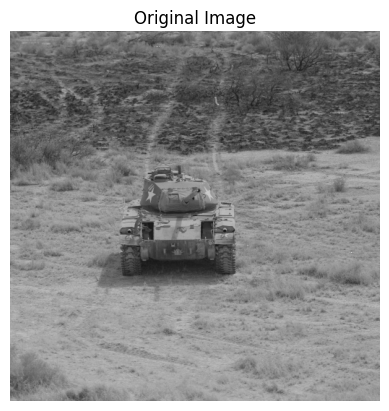

In [4]:
import os
import urllib.request

import cv2
import matplotlib.pyplot as plt

data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

url = "https://data.kitware.com/api/v1/item/6596fde89c30d6f4e17c9efc/download"

img_path = os.path.join(data_dir, "M-41 Walker Bulldog (USA) width 319cm height 272cm.tiff")
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310

img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Failed to load image: {img_path}")

fig, ax = plt.subplots()
ax.imshow(img)
ax.set_title("Original Image")
ax.set_axis_off()

The code block below shows the loading of the image above and the calling of the perturber. It is important to note that the Ground Sample Distance (or ``img_gsd``) is
another parameter the user will have to provide. The resulting image is displayed below
the code block.

```{tip}
GSD (Ground Sample Distance) is the distance between the centers of two adjacent
pixels in an image, measured on the ground. A smaller GSD (more pixels per ground area)
means a higher resolution image, capturing more detail. Conversely, a larger GSD (fewer
pixels per ground area) means a lower resolution image, capturing less detail.
```

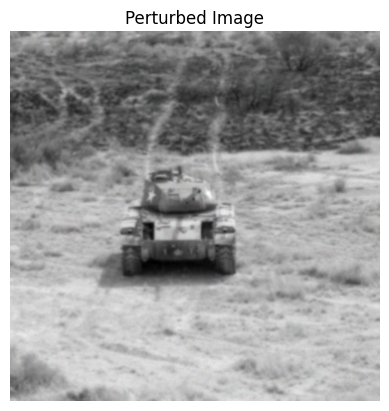

In [5]:
img_gsd = 3.19 / 165.0  # the width of the tank is 319 cm and it spans ~165 pixels in the image
perturbed_image, _ = perturber(image=img, img_gsd=img_gsd)

fig, ax = plt.subplots()
ax.imshow(perturbed_image)
ax.set_title("Perturbed Image")
ax.set_axis_off()

From the perturbed image above, we can observe a blurred output image. It is important
to note that this is simulated by a sensor with a telescope focal length (``f``) of 4
metres, detector pitch (``p``) of 8 millimeters and telescope diameter (``D``) of 275
millimeters. In the given scenario, the sensor is at 9000 meters above ground level
(``altitude``) mounted on an aircraft moving at 100 meters per second (``aircraft_speed``). 

Any of the parameters in either ``sensor_config`` or ``scenario_config`` can be modified;
however, the ``PybsmPerturber`` basic perturber can modify only a single parameter for
each instance call. The next section will cover modifying multiple parameters and
multiple values using perturber factories.

## Perturbation Factories

Continuing on from the previous example, the snippet below shows the initialization of a
``PerturberMultivariateFactory``. The ``theta_keys`` variable controls which parameter(s) we are modifying
and ``thetas`` are the actual values of the parameter(s). In this example, we are modifying the
focal length (``f``) with the values of 1, 2, and 3. The modified images are displayed below the
code block.

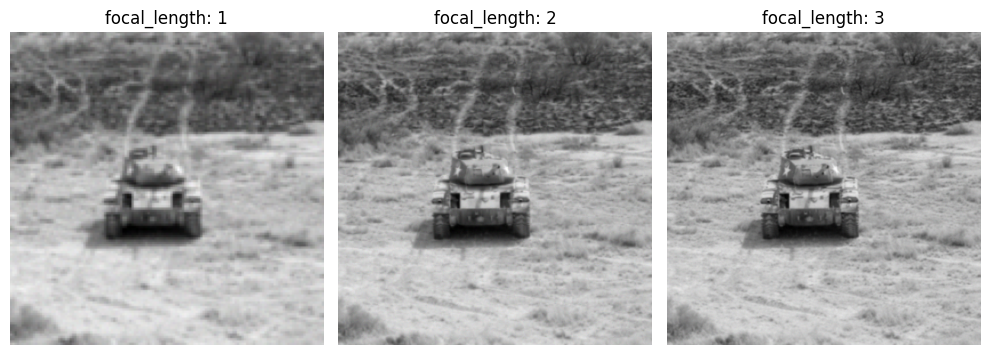

In [6]:
from nrtk.impls.perturb_image_factory import PerturberMultivariateFactory

focal_length_pf = PerturberMultivariateFactory(
    perturber=PybsmPerturber,
    theta_keys=["f"],
    thetas=[[1, 2, 3]],
    perturber_kwargs=sensor_and_scenario_config,
)

_, ax = plt.subplots(1, 3, figsize=(10, 4))
for idx, perturber in enumerate(focal_length_pf):
    perturbed_img, _ = perturber(image=img, img_gsd=img_gsd)
    ax[idx].set_title(f"focal_length: {idx + 1}")
    ax[idx].imshow(perturbed_img)
    _ = ax[idx].axis("off")
plt.tight_layout()

From the generated output images above, we can observe that as focal length increases
from 1 to 3 meters, a sharper image of the tank is generated indicating that,
comparatively, a focal length of 3 meters is preferable to get a sharper image of the tank.


Using the ``PerturberMultivariateFactory``, it is possible to assign series of values
to one or more parameters simultaneously. Each ``PerturberMultivariateFactory``
instance consists of a series of individual perturber instances based on the number of
parameter-value combinations. 

The code block below shows the focal length and ground range variables being modified.
The resulting images are displayed below the code block.

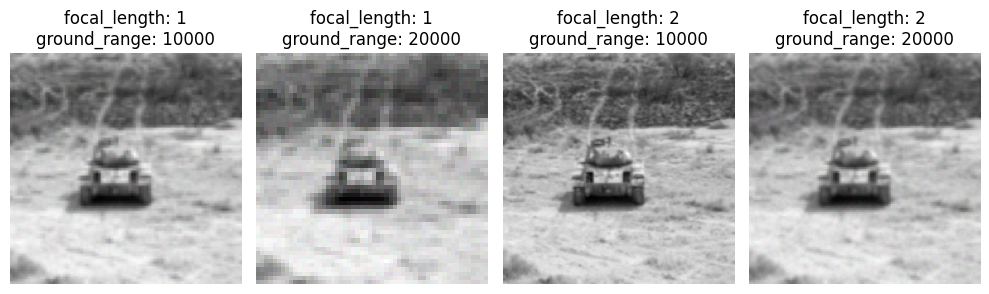

In [7]:
import itertools

f_groung_range_pf = PerturberMultivariateFactory(
    perturber=PybsmPerturber,
    theta_keys=["f", "ground_range"],
    thetas=[[1, 2], [10000, 20000]],
    perturber_kwargs=sensor_and_scenario_config,
)
perturber_factory_config = f_groung_range_pf.get_config()
if "theta_keys" in perturber_factory_config:  # pyBSM doesn't follow interface rules
    perturb_factory_keys = perturber_factory_config["theta_keys"]
    thetas = f_groung_range_pf.thetas
else:
    perturb_factory_keys = [f_groung_range_pf.theta_key]
    thetas = [f_groung_range_pf.thetas]
perturber_combinations = [dict(zip(perturb_factory_keys, v, strict=False)) for v in itertools.product(*thetas)]

_, ax = plt.subplots(1, 4, figsize=(10, 4))
for idx, perturber in enumerate(f_groung_range_pf):
    perturbed_img, _ = perturber(image=img, img_gsd=img_gsd)
    ax[idx].set_title(
        f"focal_length: {perturber_combinations[idx]['f']}\n"
        f"ground_range: {perturber_combinations[idx]['ground_range']}",
    )
    ax[idx].imshow(perturbed_img)
    _ = ax[idx].axis("off")
plt.tight_layout()

In the above images, it is important to note that the simulation does not follow a linear
progression as seen in the prior example. When modifying multiple parameters
simultaneously, we can observe drastic changes in the image texture (blurring
and subsampling effects) as we sweep through to find the optimal combination for the
``f`` (focal_length) and ``ground_range`` parameters.

## Model Evaluation

NRTK's image perturbation tools are often used in conjunction with evaluation workflows such as [Modular AI Trustworthy Engineering (MAITE)](https://github.com/mit-ll-ai-technology/maite), which support modular test configuration and scoring. If you're working within a JATIC ecosystem or evaluating robustness at scale, tools like MAITE help integrate perturbations into end-to-end pipelines. 

```{seealso}
See our [Testing & Evaluation (T&E) Guides](<project:/tutorials/testing_and_evaluation_notebooks.rst>) for tutorials on evaluating models against operational risks using NRTK and MAITE.
```